# Replacing aloan officer

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pylab
import seaborn as sns
import sklearn.svm as svm

%matplotlib inline
sns.set(style="darkgrid") # Set plot style to that of seaborn
mpl.rcParams['figure.figsize'] = 14, 10 # Change default figure size

# Generate historical loan data

In [2]:
def generate_loan_history():
    """
    Returns X - the loan taker description and
            y - the loan outcome (ontime/default)
    """
    ontime = np.random.choice([True, False])
    fico = np.random.normal(730,40) if ontime else np.random.normal(620,40)
    income = np.random.normal(80000,12000) if ontime else np.random.normal(50000,12000)
    age =  np.random.randint(23, 50) if ontime else np.random.choice([np.random.randint(18, 25), np.random.randint(45, 55)])
    likes_dogs = np.random.choice([True, False])
    return np.array([fico, income, age, likes_dogs, ontime])

samples = 1000
loans = [generate_loan_history() for _ in range(samples)]
X, y = np.array([loan[:-1] for loan in loans])\
     , np.array([loan[-1] for loan in loans])

## Display loans historical information in a table

In [3]:
pd.DataFrame(loans, columns=['fico [-]', 'income [€]', 'Age [y]', 'Likes dogs', 'ontime'])

,fico [-],income [€],Age [y],Likes dogs,ontime
0,663.204599,50387.282325,52.0,0.0,0.0
1,693.298336,30210.211799,24.0,0.0,0.0
2,564.194614,66204.673816,48.0,0.0,0.0
3,763.648409,87763.847527,36.0,0.0,1.0
4,635.085650,57729.150169,22.0,1.0,0.0
5,692.938129,74551.166042,31.0,0.0,1.0
6,642.421188,50210.260596,24.0,0.0,0.0
7,582.835687,45348.392941,21.0,0.0,0.0
8,780.247940,64122.132148,34.0,1.0,1.0
9,723.901358,73991.266150,25.0,1.0,1.0


# Visualization method

In [4]:
def display_model(clf, X, y, x_label='', y_label='', title='', mesh_steps=100):
    x_min, y_min, x_max, y_max = (m(X[:, i]) for m in [min, max] for i in range(X.shape[1]))
    
    h = min(y_max - y_min, x_max - x_min) / mesh_steps
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h)
                        , np.arange(y_min, y_max, h))
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, s=50)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    plt.title(title)
    plt.show()

# Train SVM classifier

* [sklear.svm documentation](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)

Here we use SVM (Supported Vector Machines) classifier for predicting loan outcomes.

...

In [5]:
C = 1.0  # SVM regularization parameter

C:\Users\jarekh\AppData\Local\Continuum\Anaconda3\lib\site-packages\numpy\ma\core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
C:\Users\jarekh\AppData\Local\Continuum\Anaconda3\lib\site-packages\numpy\ma\core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


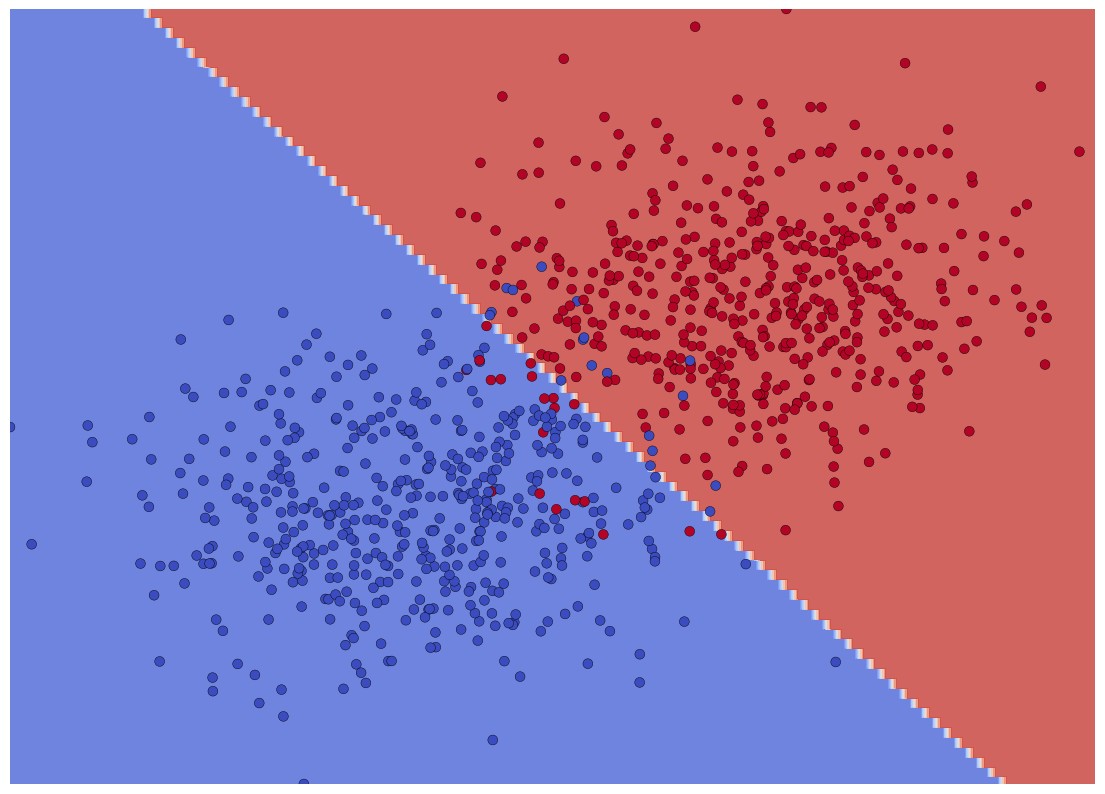

In [6]:
svc = svm.SVC(kernel='linear', C=C).fit(X[:, 0:2], y)
display_model(svc, X[:, 0:2], y)

# Back to decision trees

In [7]:
import os
import pydotplus

from io import StringIO
from IPython.display import Image

from sklearn import tree
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.8)

def save_decision_tree_graph(clf, fn):
    dot_data = StringIO()
    tree.export_graphviz(clf
                        , out_file=dot_data
                        , feature_names=['fico [-]', 'income [€]', 'Age [y]', 'Likes dogs']
                        , class_names = ['default', 'ontime']
                        , filled=True
                        , rounded=True
                        , impurity=False)

    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

    if not os.path.exists('saved'):
        os.makedirs('saved')

    graph.write_pdf('saved/{}.pdf'.format(fn))
    graph.write_png('saved/{}.png'.format(fn))
    
    Image(filename='saved/{}.png'.format(fn))

In [8]:
loan_clf = tree.DecisionTreeClassifier()
loan_clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

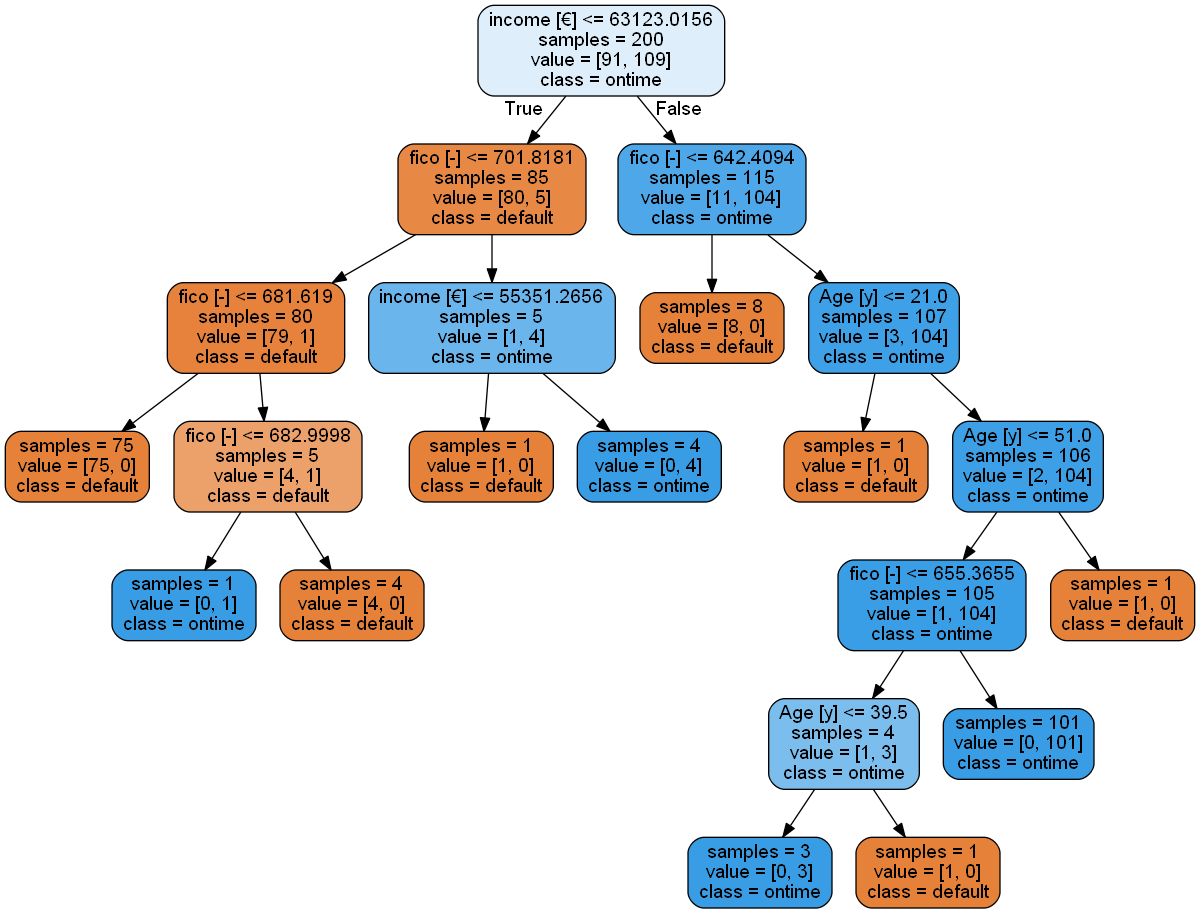

In [9]:
save_decision_tree_graph(loan_clf, 'loan_clf')
Image(filename='saved/loan_clf.png')